<a href="https://colab.research.google.com/github/GUEST72/CSC311-Machine-Learning-projects/blob/main/assignment_2/Custom_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
import os

#Set_device (use GPU)
device = torch.device("cuda")
print(f"Using device: {device}")
torch.manual_seed(27)

Using device: cuda


In [2]:
# Transform: Normalize to [0,1] (ToTensor does this)
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])


# Load MNIST train and test sets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Combine them to split across all data
full_dataset = ConcatDataset([train_dataset, test_dataset])
# Get all labels for stratification
labels = [full_dataset[i][1] for i in range(len(full_dataset))]

# Split indices: 60% train, 40% temp (then split temp into 50% val, 50% test → 20% each)
train_idx, temp_idx = train_test_split(range(len(full_dataset)), test_size=0.4, stratify=labels, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx], random_state=42)

# Create subsets
train_set = Subset(full_dataset, train_idx)
val_set = Subset(full_dataset, val_idx)
test_set = Subset(full_dataset, test_idx)

# Function to create DataLoaders (we'll use this later with different batch sizes)
def get_dataloaders(batch_size=64):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

# Create baseline loaders
train_loader, val_loader, test_loader = get_dataloaders()

print(f"Train size: {len(train_set)}, Val size: {len(val_set)}, Test size: {len(test_set)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 513kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.59MB/s]


Train size: 42000, Val size: 14000, Test size: 14000


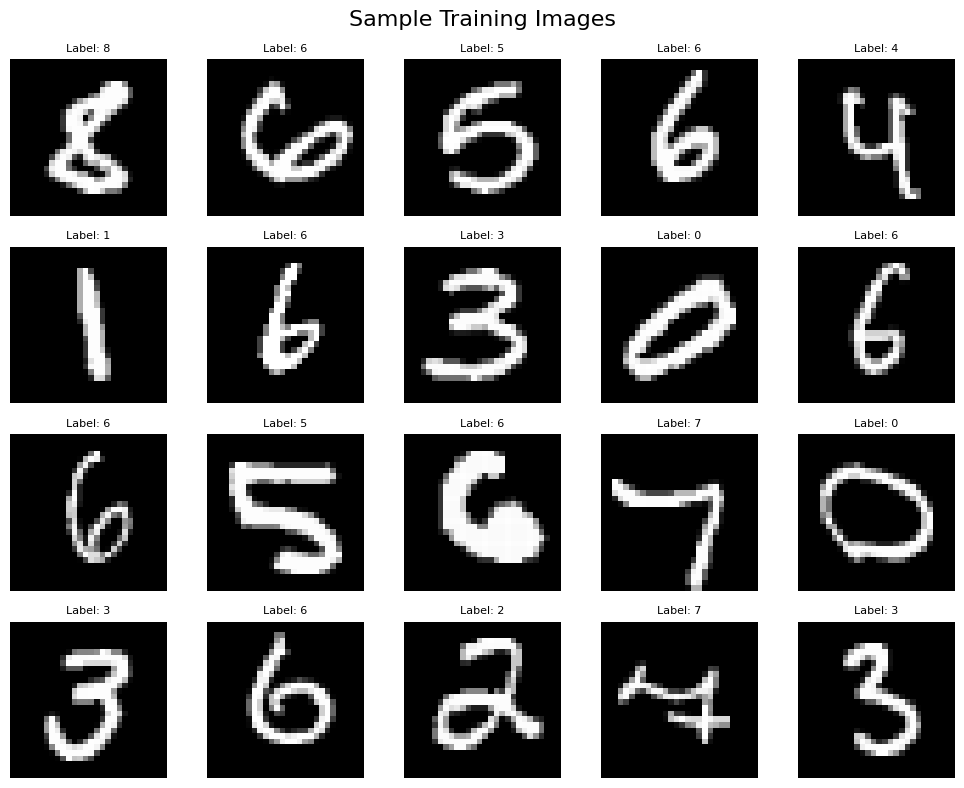

In [3]:
import matplotlib.pyplot as plt

# Get a sample
dataiter = iter(train_loader)
images, labels = next(dataiter)


fig, axes = plt.subplots(4, 5, figsize=(10, 8))
fig.suptitle("Sample Training Images", fontsize=16)
for idx, ax in enumerate(axes.flat):
    ax.imshow(images[idx].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[idx].item()}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [4]:
class CustomNN(nn.Module):
    # Define the neural network architecture
    def __init__(self, input_size=784, hidden_sizes=[128, 64], output_size=10, dropout_prob=0.0, use_batchnorm=False):
        super(CustomNN, self).__init__()
        # Flexible: hidden_sizes is a list for multiple hidden layers
        self.activation_fn = nn.ReLU() # Using ReLU as the activation function

        # Create a list to hold the layers of the network
        self.layers = nn.ModuleList()
        prev_size = input_size # Initialize the size of the input to the first layer

        # Build the hidden layers based on the hidden_sizes list
        for hidden_size in hidden_sizes:

            # Add a linear (fully connected) layer
            layer = nn.Linear(prev_size, hidden_size)
            nn.init.xavier_uniform_(layer.weight)  # Initialize weights using Xavier uniform initialization

            self.layers.append(layer)

            # Optionally add Batch Normalization
            if use_batchnorm:
                self.layers.append(nn.BatchNorm1d(hidden_size))

            # Add the activation function after the linear layer (and BatchNorm if used)
            self.layers.append(self.activation_fn)

            # Optionally add Dropout for regularization
            if dropout_prob > 0:
                self.layers.append(nn.Dropout(p=dropout_prob))

            prev_size = hidden_size # Update the input size for the next layer

        # Add the output layer
        self.output = nn.Linear(prev_size, output_size)
        nn.init.xavier_uniform_(self.output.weight) # Initialize weights for the output layer

    # Define the forward pass of the network
    def forward(self, x):
        # Flatten the input image
        x = x.view(x.size(0), -1)  # Reshape to batch_size x (input_size)

        # Pass the input through the sequence of hidden layers
        for layer in self.layers:
           x = layer(x)

        # Pass the output of the hidden layers through the final output layer
        x = self.output(x)
        return x # Return the output logits

In [5]:
def run_epoch(model, loader, criterion, optimizer=None):
    # Determine if it's a training epoch based on whether an optimizer is provided
    is_train = optimizer is not None
    # Set the model to training mode if optimizer is provided, otherwise set to evaluation mode
    model.train() if is_train else model.eval()

    total_loss, total_correct = 0, 0

    for images, labels in loader:
        # Move data to the specified device (GPU)
        images, labels = images.to(device), labels.to(device)

        # Perform forward pass: get model predictions (logits)
        outputs = model(images)

        # Calculate the loss between model outputs and true labels
        loss = criterion(outputs, labels)

        # Perform backward pass and optimization only in training mode
        if is_train:
            optimizer.zero_grad() # Clear previous gradients
            loss.backward()       # Compute gradient of the loss with respect to model parameters
            optimizer.step()      # Update model parameters using the gradients and optimizer

        # Accumulate loss and count correct predictions
        total_loss += loss.item() * images.size(0) # Sum of loss for each sample in the batch
        # Get the index of the max log-probability (the predicted class)
        # Compare predictions with true labels and sum up correct ones
        total_correct += (outputs.argmax(1) == labels).sum().item()

    # Calculate average loss and accuracy for the entire epoch
    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_correct / len(loader.dataset)
    return avg_loss, avg_acc

In [6]:
def train_model(model, train_loader, val_loader, lr=0.01, epochs=20, verbose=True):
    model = model.to(device) # Move model to the device
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = run_epoch(model, val_loader, criterion)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        if verbose:
         print(f"Epoch {epoch+1}/{epochs} | " f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | " f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

Epoch 1/20 | Train Loss: 1.0995 Acc: 0.7211 | Val Loss: 0.5358 Acc: 0.8609
Epoch 2/20 | Train Loss: 0.4353 Acc: 0.8821 | Val Loss: 0.3830 Acc: 0.8925
Epoch 3/20 | Train Loss: 0.3449 Acc: 0.9033 | Val Loss: 0.3295 Acc: 0.9071
Epoch 4/20 | Train Loss: 0.3035 Acc: 0.9142 | Val Loss: 0.2997 Acc: 0.9158
Epoch 5/20 | Train Loss: 0.2771 Acc: 0.9208 | Val Loss: 0.2837 Acc: 0.9167
Epoch 6/20 | Train Loss: 0.2567 Acc: 0.9265 | Val Loss: 0.2739 Acc: 0.9205
Epoch 7/20 | Train Loss: 0.2401 Acc: 0.9316 | Val Loss: 0.2513 Acc: 0.9264
Epoch 8/20 | Train Loss: 0.2259 Acc: 0.9358 | Val Loss: 0.2382 Acc: 0.9311
Epoch 9/20 | Train Loss: 0.2138 Acc: 0.9388 | Val Loss: 0.2268 Acc: 0.9342
Epoch 10/20 | Train Loss: 0.2027 Acc: 0.9424 | Val Loss: 0.2172 Acc: 0.9355
Epoch 11/20 | Train Loss: 0.1928 Acc: 0.9450 | Val Loss: 0.2079 Acc: 0.9387
Epoch 12/20 | Train Loss: 0.1836 Acc: 0.9474 | Val Loss: 0.2012 Acc: 0.9414
Epoch 13/20 | Train Loss: 0.1754 Acc: 0.9492 | Val Loss: 0.2019 Acc: 0.9414
Epoch 14/20 | Train L

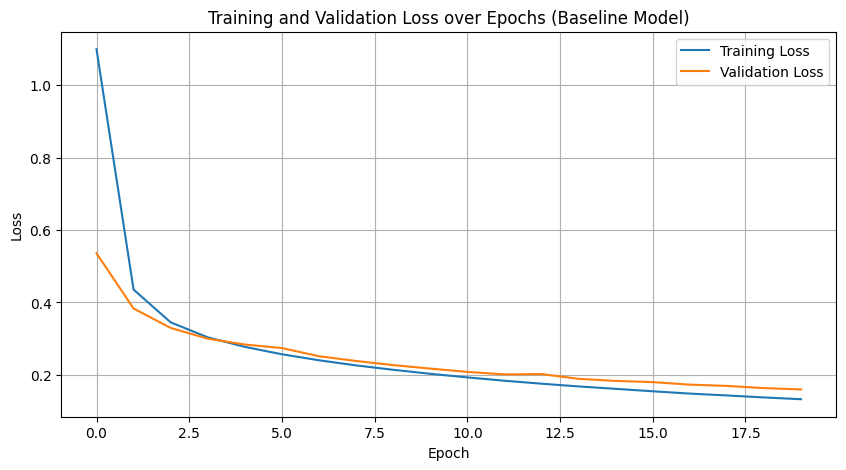

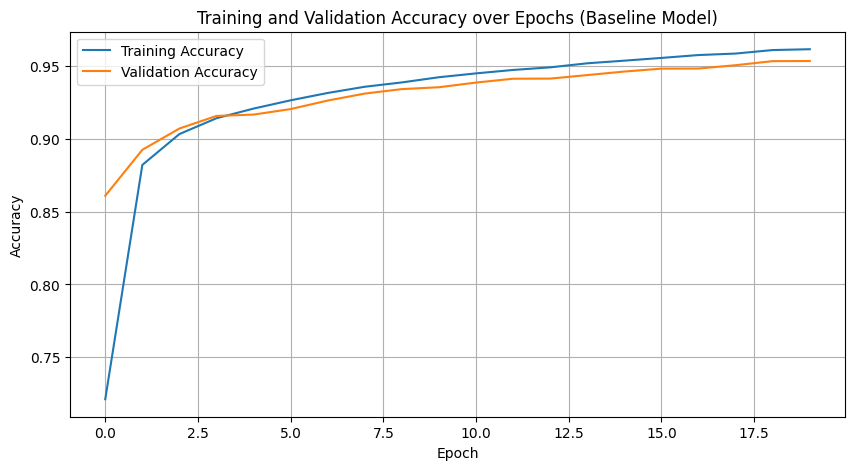


Running 5 trials for error bars...
Trial 1/5
Trial 2/5
Trial 3/5
Trial 4/5
Trial 5/5


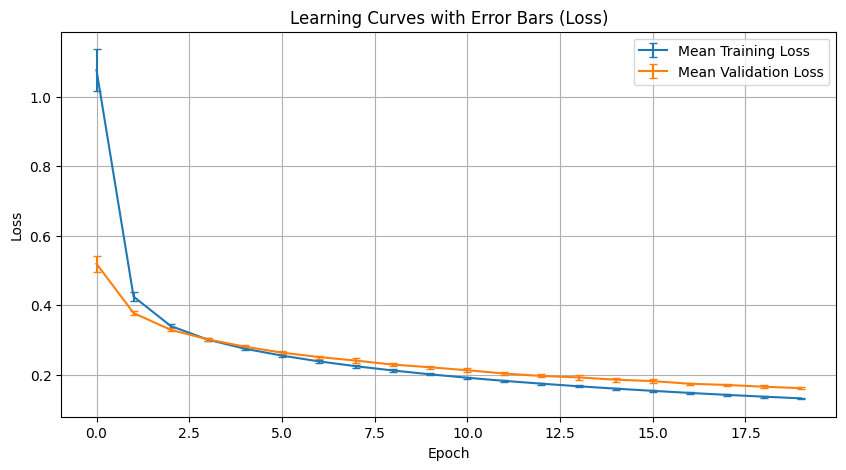

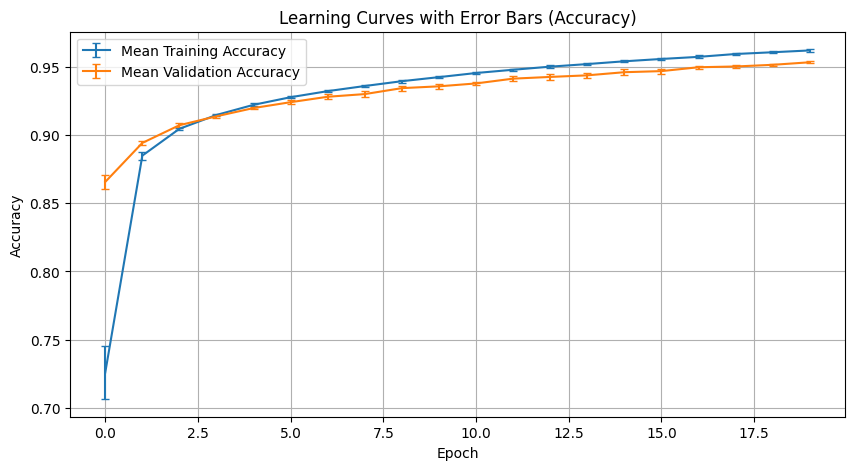

In [8]:
# Assuming a baseline model was trained and its history saved in a variable like `baseline_history`
# If not, train a baseline model first and store its history

# Example: Train a baseline model with default parameters (lr=0.01, epochs=20, no dropout, no batchnorm)
baseline_model = CustomNN()
baseline_history = train_model(baseline_model, train_loader, val_loader, lr=0.01, epochs=20, verbose=True)


# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(baseline_history['train_losses'], label='Training Loss')
plt.plot(baseline_history['val_losses'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs (Baseline Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(baseline_history['train_accs'], label='Training Accuracy')
plt.plot(baseline_history['val_accs'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs (Baseline Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Learning curves with error bars - This requires running multiple trials
# We will run the training multiple times with different random seeds
num_seeds = 5 # Number of runs for error bars
num_epochs = 20 # Number of epochs for each run
lr = 0.01 # Learning rate for baseline model

all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []

print(f"\nRunning {num_seeds} trials for error bars...")
for s in range(num_seeds):
    print(f"Trial {s+1}/{num_seeds}")
    torch.manual_seed(s) # Set different seed for each run
    model = CustomNN()
    history = train_model(model, train_loader, val_loader, lr=lr, epochs=num_epochs, verbose=False)
    all_train_losses.append(history['train_losses'])
    all_val_losses.append(history['val_losses'])
    all_train_accs.append(history['train_accs'])
    all_val_accs.append(history['val_accs'])

# Convert lists of lists to numpy arrays for easier calculation
all_train_losses = np.array(all_train_losses)
all_val_losses = np.array(all_val_losses)
all_train_accs = np.array(all_train_accs)
all_val_accs = np.array(all_val_accs)

# Calculate mean and standard deviation
mean_train_losses = np.mean(all_train_losses, axis=0)
std_train_losses = np.std(all_train_losses, axis=0)
mean_val_losses = np.mean(all_val_losses, axis=0)
std_val_losses = np.std(all_val_losses, axis=0)

mean_train_accs = np.mean(all_train_accs, axis=0)
std_train_accs = np.std(all_train_accs, axis=0)
mean_val_accs = np.mean(all_val_accs, axis=0)
std_val_accs = np.std(all_val_accs, axis=0)


# Plot Learning Curves with Error Bars (Loss)
plt.figure(figsize=(10, 5))
plt.errorbar(range(num_epochs), mean_train_losses, yerr=std_train_losses, label='Mean Training Loss', capsize=3)
plt.errorbar(range(num_epochs), mean_val_losses, yerr=std_val_losses, label='Mean Validation Loss', capsize=3)
plt.title('Learning Curves with Error Bars (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Learning Curves with Error Bars (Accuracy)
plt.figure(figsize=(10, 5))
plt.errorbar(range(num_epochs), mean_train_accs, yerr=std_train_accs, label='Mean Training Accuracy', capsize=3)
plt.errorbar(range(num_epochs), mean_val_accs, yerr=std_val_accs, label='Mean Validation Accuracy', capsize=3)
plt.title('Learning Curves with Error Bars (Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Convergence Analysis
The plots above illustrate the convergence behavior of the baseline model.
- The **Loss over Epochs** plot shows how the training and validation loss decrease as training progresses. Convergence is typically reached when the loss stops decreasing significantly."

- The **Accuracy over Epochs** plot shows how the training and validation accuracy increase. Convergence is typically reached when the accuracy plateaus.

- The **Learning Curves with Error Bars** plots provide a more robust view of convergence by showing the average performance and variability across multiple training runs. Narrow error bars indicate consistent convergence."


In [9]:
results_lr, results_bs, results_arch = [], [], []

In [12]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
for lr in learning_rates:
    print(f"\n[LR Test] Learning Rate = {lr}")
    model = CustomNN()
    history = train_model(model, train_loader, val_loader, lr=lr, epochs=10,verbose=False)
    results_lr.append({
        'LR': lr,
        'Final Train Acc': history['train_accs'][-1],
        'Final Val Acc': history['val_accs'][-1],
        'Train Loss Curve': history['train_losses'],
        'Val Loss Curve': history['val_losses']
    })


[LR Test] Learning Rate = 0.001

[LR Test] Learning Rate = 0.01

[LR Test] Learning Rate = 0.1

[LR Test] Learning Rate = 1.0


In [13]:
batch_sizes = [16, 32, 64, 128]
for bs in batch_sizes:
    print(f"\n[Batch Size Test] BS = {bs}")
    train_loader_bs, val_loader_bs, _ = get_dataloaders(batch_size=bs)
    model = CustomNN()
    history = train_model(model, train_loader_bs, val_loader_bs, lr=0.01, epochs=10,verbose=False)
    results_bs.append({
        'Batch Size': bs,
        'Final Train Acc': history['train_accs'][-1],
        'Final Val Acc': history['val_accs'][-1]
    })


[Batch Size Test] BS = 16

[Batch Size Test] BS = 32

[Batch Size Test] BS = 64

[Batch Size Test] BS = 128


In [14]:
layer_options = [2, 3, 4, 5]
neurons_options = [64, 128, 256, 512]

for layers in layer_options:
    for neurons in neurons_options:
        hidden_sizes = [neurons] * layers
        print(f"\n[Arch Test] Layers = {layers}, Neurons = {neurons}")
        model = CustomNN(hidden_sizes=hidden_sizes)
        history = train_model(model, train_loader, val_loader, lr=0.01, epochs=10,verbose=False)
        results_arch.append({
            'Layers': layers,
            'Neurons per Layer': neurons,
            'Final Train Acc': history['train_accs'][-1],
            'Final Val Acc': history['val_accs'][-1]
        })


[Arch Test] Layers = 2, Neurons = 64

[Arch Test] Layers = 2, Neurons = 128

[Arch Test] Layers = 2, Neurons = 256

[Arch Test] Layers = 2, Neurons = 512

[Arch Test] Layers = 3, Neurons = 64

[Arch Test] Layers = 3, Neurons = 128

[Arch Test] Layers = 3, Neurons = 256

[Arch Test] Layers = 3, Neurons = 512

[Arch Test] Layers = 4, Neurons = 64

[Arch Test] Layers = 4, Neurons = 128

[Arch Test] Layers = 4, Neurons = 256

[Arch Test] Layers = 4, Neurons = 512

[Arch Test] Layers = 5, Neurons = 64

[Arch Test] Layers = 5, Neurons = 128

[Arch Test] Layers = 5, Neurons = 256

[Arch Test] Layers = 5, Neurons = 512


In [15]:
df_lr = pd.DataFrame(results_lr)
df_bs = pd.DataFrame(results_bs)
df_arch = pd.DataFrame(results_arch)

print("\n=== Learning Rate Results ===")
print(df_lr[['LR', 'Final Train Acc', 'Final Val Acc']])

print("\n=== Batch Size Results ===")
print(df_bs)

print("\n=== Architecture Results ===")
print(df_arch)



=== Learning Rate Results ===
      LR  Final Train Acc  Final Val Acc
0  0.001         0.872714       0.875071
1  0.010         0.943143       0.936643
2  0.100         0.989714       0.970929
3  1.000         0.954952       0.933071

=== Batch Size Results ===
   Batch Size  Final Train Acc  Final Val Acc
0          16         0.974929       0.961929
1          32         0.960357       0.952429
2          64         0.942262       0.934857
3         128         0.922810       0.919786

=== Architecture Results ===
    Layers  Neurons per Layer  Final Train Acc  Final Val Acc
0        2                 64         0.934833       0.928143
1        2                128         0.942381       0.935429
2        2                256         0.946000       0.939571
3        2                512         0.948405       0.940571
4        3                 64         0.946024       0.938929
5        3                128         0.951167       0.946214
6        3                256         0.95

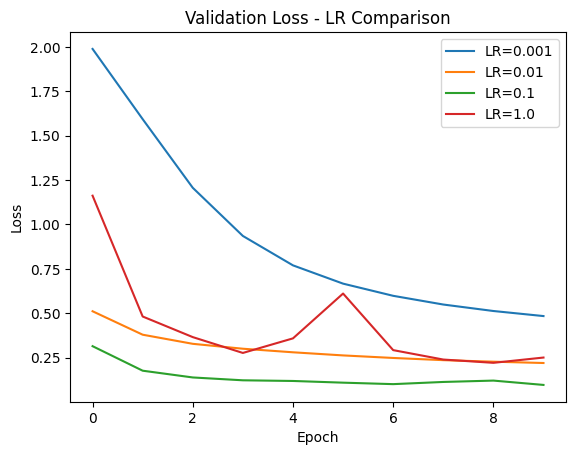

In [16]:
plt.figure()
for res in results_lr:
    plt.plot(res['Val Loss Curve'], label=f"LR={res['LR']}")
plt.title("Validation Loss - LR Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
dropout_rates = [0.1, 0.3, 0.5, 0.7]
use_bn_options = [False, True]

results = []

for bn in use_bn_options:
    for dr in dropout_rates:
        print(f"\n=== Running: Dropout={dr}, BatchNorm={bn} ===")
        model = CustomNN(dropout_prob=dr, use_batchnorm=bn)
        history = train_model(model, train_loader, val_loader, lr=0.01, epochs=10,verbose=False)

        results.append({
            'Dropout': dr,
            'BatchNorm': bn,
            'Final Train Acc': history['train_accs'][-1],
            'Final Val Acc': history['val_accs'][-1],
            'Train Loss Curve': history['train_losses'],
            'Val Loss Curve': history['val_losses'],
            'Train Acc Curve': history['train_accs'],
            'Val Acc Curve': history['val_accs']
        })



=== Running: Dropout=0.1, BatchNorm=False ===

=== Running: Dropout=0.3, BatchNorm=False ===

=== Running: Dropout=0.5, BatchNorm=False ===

=== Running: Dropout=0.7, BatchNorm=False ===

=== Running: Dropout=0.1, BatchNorm=True ===

=== Running: Dropout=0.3, BatchNorm=True ===

=== Running: Dropout=0.5, BatchNorm=True ===

=== Running: Dropout=0.7, BatchNorm=True ===


In [18]:
df_results = pd.DataFrame(results)
print(df_results[['Dropout', 'BatchNorm', 'Final Train Acc', 'Final Val Acc']])


   Dropout  BatchNorm  Final Train Acc  Final Val Acc
0      0.1      False         0.929810       0.937143
1      0.3      False         0.904571       0.932929
2      0.5      False         0.865810       0.924143
3      0.7      False         0.762786       0.905857
4      0.1       True         0.949357       0.957214
5      0.3       True         0.912357       0.946000
6      0.5       True         0.859786       0.928214
7      0.7       True         0.745810       0.903357


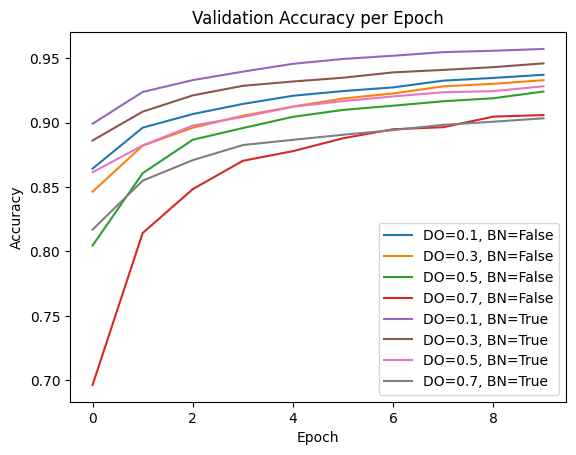

In [19]:
for res in results:
    label = f"DO={res['Dropout']}, BN={res['BatchNorm']}"
    plt.plot(res['Val Acc Curve'], label=label)

plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [20]:
# Find best Learning Rate
best_lr_result = max(results_lr, key=lambda x: x['Final Val Acc'])
best_lr = best_lr_result['LR']

# Find best Batch Size
best_bs_result = max(results_bs, key=lambda x: x['Final Val Acc'])
best_batch_size = best_bs_result['Batch Size']

# Find best Architecture
best_arch_result = max(results_arch, key=lambda x: x['Final Val Acc'])
best_hidden_sizes = [best_arch_result['Neurons per Layer']] * best_arch_result['Layers']

# Find best Dropout + BatchNorm combination
best_reg_result = max(results, key=lambda x: x['Final Val Acc'])
best_dropout = best_reg_result['Dropout']
best_batchnorm = best_reg_result['BatchNorm']

# Collect all best hyperparameters
best_hyperparameters = [
    {'type': 'learning_rate', 'value': best_lr, 'val_acc': best_lr_result['Final Val Acc']},
    {'type': 'batch_size', 'value': best_batch_size, 'val_acc': best_bs_result['Final Val Acc']},
    {'type': 'architecture', 'value': best_hidden_sizes, 'val_acc': best_arch_result['Final Val Acc']},
    {'type': 'dropout', 'value': best_dropout, 'val_acc': best_reg_result['Final Val Acc']},
    {'type': 'batchnorm', 'value': best_batchnorm, 'val_acc': best_reg_result['Final Val Acc']}
]

# Create final best configuration combining all best hyperparameters
best_config = {
    "learning_rate": best_lr,
    "batch_size": best_batch_size,
    "hidden_layers": best_hidden_sizes,
    "dropout": best_dropout,
    "use_batchnorm": best_batchnorm
}

print("=" * 60)
print("BEST HYPERPARAMETERS FROM EACH EXPERIMENT:")
print("=" * 60)
for hp in best_hyperparameters:
    print(f"{hp['type']}: {hp['value']} (Val Acc: {hp['val_acc']:.4f})")

print("\n" + "=" * 60)
print("COMBINED BEST CONFIGURATION:")
print("=" * 60)
for key, value in best_config.items():
    print(f"{key}: {value}")

BEST HYPERPARAMETERS FROM EACH EXPERIMENT:
learning_rate: 0.1 (Val Acc: 0.9709)
batch_size: 16 (Val Acc: 0.9619)
architecture: [512, 512, 512, 512, 512] (Val Acc: 0.9587)
dropout: 0.1 (Val Acc: 0.9572)
batchnorm: True (Val Acc: 0.9572)

COMBINED BEST CONFIGURATION:
learning_rate: 0.1
batch_size: 16
hidden_layers: [512, 512, 512, 512, 512]
dropout: 0.1
use_batchnorm: True


In [21]:
def train_final_model(best_config, train_loader, val_loader, epochs=20):
    """Trains a model with the best hyperparameters."""
    model = CustomNN(hidden_sizes=best_config['hidden_layers'],
                      dropout_prob=best_config['dropout'],
                      use_batchnorm=best_config['use_batchnorm'])

    print("\nTraining the final model with the best hyperparameters...")

    # Use the best batch size for the final training and validation loaders
    train_loader_final, val_loader_final, _ = get_dataloaders(batch_size=best_config['batch_size'])

    final_history = train_model(model, train_loader_final, val_loader_final,
                                lr=best_config['learning_rate'], epochs=epochs,verbose=False)

    return model, final_history

In [22]:
def predict_on_test_set(model, test_loader):
    """Evaluates the trained model on the test set."""
    model.to(device) # Ensure model is on the device for evaluation
    model.eval() # Set model to evaluation mode
    criterion = nn.CrossEntropyLoss() # Use the same criterion as training

    test_loss, test_acc = run_epoch(model, test_loader, criterion)

    print("=" * 60)
    print("FINAL MODEL EVALUATION ON TEST SET:")
    print("=" * 60)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    return test_loss, test_acc

In [23]:
_, _, test_loader_final = get_dataloaders(batch_size=best_config['batch_size'])

# Train the model
final_model, final_history = train_final_model(best_config, train_loader, val_loader, epochs=20)

# Make predictions
test_loss, test_acc = predict_on_test_set(final_model, test_loader_final)


Training the final model with the best hyperparameters...
FINAL MODEL EVALUATION ON TEST SET:
Test Loss: 0.0631
Test Accuracy: 0.9820
